In [1]:
library(microbiome)
library(phyloseq); packageVersion("phyloseq")
library("tidyverse")
library("dplyr")
library(vegan)
#library("lubridate")
library('PCAtools')
library("GGally")
library("ggpmisc")
library("speedyseq")
library(patchwork)
library("pairwiseAdonis"); packageVersion("pairwiseAdonis")


Loading required package: phyloseq

Loading required package: ggplot2


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2022 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

    transform




[1] ‘1.46.0’

── Attaching core tidyverse packages ────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ──────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ microbiome::alpha() masks ggplot2::alpha()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4


Attaching package: ‘vegan’


The following object is masked from ‘package:microbiome’:

    diversity


Loading required package: ggrepel


Attaching package: ‘PCAtools’


The following objects are masked from ‘package:stats’:

    biplot, screeplot


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   gg

[1] ‘0.4.1’

In [2]:
load("/Users/stephanie.rosales/Documents/omics_projects/POR_16S/CoralPersistence/data/POR_counts_4_analysis.RData")
load("/Users/stephanie.rosales/Documents/omics_projects/POR_16S/CoralPersistence/data/POR_taxo_4_analysis.RData")


In [3]:
#load metadata
meta = read.csv ("/Users/stephanie.rosales/Documents/omics_projects/POR_16S/CoralPersistence/metadata/POR_combo_meta.csv",
row.names=1, header = T)%>%
  mutate(
    Month = factor(Month, levels = month.name)
  ) %>%
  arrange(Month) %>%
arrange(collection_date)

head(meta, n=2)

,collection_date,Speed.cm.s.,Bearing.degrees.,Velocity.N.cm.s.,Velocity.E.cm.s.,Temperature.C.,reef,Genotype,Fragment_number,Month,⋯,cluster_depth,depth,Year.y,Month.y,Lat_decimal,Long_decimal,avgchla_mgm.3,sdchla_mgm.3,avgSST_degC,sdSST_degC
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>,⋯,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bagnumber-584,1-Mar-19,5.331549,147.0395,-1.81184,-0.7369632,26.09619,pr,CN2,3,March,⋯,-15.7,15.7,2019,March,24.985,-80.416,0.3999531,0.163012,25.99442,0.2483825
bagnumber-585,1-Mar-19,5.331549,147.0395,-1.81184,-0.7369632,26.09619,pr,CN2,4,March,⋯,-15.7,15.7,2019,March,24.985,-80.416,0.3999531,0.163012,25.99442,0.2483825


In [4]:
## taxonomy and counts as matrices
taxo_mat <- as.matrix(POR_taxo_4_analysis)
count_mat <- as.matrix(POR_counts_4_analysis)

In [5]:
#make phyloseq object
ASV <- otu_table(as.matrix(POR_counts_4_analysis), 
                 taxa_are_rows = T)
TAX <- tax_table(taxo_mat)
SAMP <- sample_data(meta)

ps <- phyloseq(ASV, TAX, SAMP)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 27534 taxa and 363 samples ]:
sample_data() Sample Data:        [ 363 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 27534 taxa by 7 taxonomic ranks ]:
taxa are rows

In [6]:
#list of ASVs that Blasted as Eukaryote
euk_asvs <- c("ASV_10673","ASV_10883",	"ASV_11806","ASV_12333",	"ASV_12335",	"ASV_13587",	"ASV_14757",	"ASV_15238",	"ASV_15259",	"ASV_16364",	"ASV_16936",	"ASV_17406",	"ASV_18096",	"ASV_18375",	"ASV_18682",	"ASV_19529",	"ASV_19795",	"ASV_19953",	"ASV_2",	"ASV_20640",	"ASV_2100",	"ASV_22284",	"ASV_22692",	"ASV_23038",	"ASV_23144",	"ASV_24135",	"ASV_24243",	"ASV_27014",	"ASV_29665",	"ASV_30547",	"ASV_30626",	"ASV_30884",	"ASV_4161",	"ASV_4498",	"ASV_476",	"ASV_4797",	"ASV_4966",	"ASV_5018",	"ASV_5118",	"ASV_5154",	"ASV_6282",	"ASV_653",	"ASV_6843",	"ASV_7264",	"ASV_7427",	"ASV_8",	"ASV_9248",	"ASV_9692")
allTaxa = taxa_names(ps)
allTaxa <- allTaxa[!(allTaxa %in% euk_asvs)]
ps_fill_euk = prune_taxa(allTaxa, ps)
# new phyloseq object with removed eukaryotes 
ps_fill_euk

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 27486 taxa and 363 samples ]:
sample_data() Sample Data:        [ 363 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 27486 taxa by 7 taxonomic ranks ]:
taxa are rows

In [7]:
ps_merge = merge_samples2(ps_fill_euk, "geno_clus")
ps_merge

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 27486 taxa and 125 samples ]:
sample_data() Sample Data:        [ 125 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 27486 taxa by 7 taxonomic ranks ]:
taxa are rows

In [8]:
#filter to remove noise from data
ps_fill = filter_taxa(ps_merge, function(x) sum(x > 10) > (0.15*length(x)), TRUE)
ps_fill


phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 481 taxa and 125 samples ]:
sample_data() Sample Data:        [ 125 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 481 taxa by 7 taxonomic ranks ]:
taxa are rows

In [9]:
# transform data into relative abundance and ordinate
ps_clr <- microbiome::transform(ps_fill, 'clr')
psr_clr_ord <- ordinate(ps_clr, "RDA", "euclidean")

### Dispersion

In [10]:

#dispersion
ps_veg <- vegdist(otu_table(t(ps_clr)), method ="euclidean")

mod_geno <- betadisper(ps_veg, sample_data(ps_clr)$Genotype, type ="centroid")
#test the pair-wise comparisons for Multivariate Homogeneity Of Groups Dispersions (Variances)

mod_dist= as.data.frame(mod_geno$distances)
dim(mod_dist)
mod_dist_df=cbind(sample_data(ps_clr), mod_dist) 

#test the pair-wise comparisons for Multivariate Homogeneity Of Groups Dispersions (Variances)
TukeyHSD(mod_geno)
permutest(mod_geno, pairwise = TRUE, permutations = 999)

#results: only  CN4-CN2 are not different


[1] 125   1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
              diff       lwr        upr     p adj
CN4-CN2 -0.4024861 -3.787672  2.9826998 0.9896482
HS1-CN2 -3.6420231 -6.795623 -0.4884228 0.0166383
ML2-CN2 -5.2504627 -8.673078 -1.8278479 0.0006352
HS1-CN4 -3.2395370 -6.665284  0.1862096 0.0709559
ML2-CN4 -4.8479766 -8.522869 -1.1730839 0.0044351
ML2-HS1 -1.6084396 -5.071177  1.8542974 0.6216858



Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq Mean Sq      F N.Perm Pr(>F)    
Groups      3  581.0 193.679 7.3482    999  0.001 ***
Residuals 121 3189.3  26.357                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Pairwise comparisons:
(Observed p-value below diagonal, permuted p-value above diagonal)
           CN2        CN4        HS1   ML2
CN2            0.77500000 0.00300000 0.001
CN4 0.77461076            0.01600000 0.001
HS1 0.00231449 0.01315906            0.176
ML2 0.00027248 0.00215234 0.18975273      

In [11]:
#dispersion
ps_veg <- vegdist(otu_table(t(ps_clr)), method ="euclidean")

mod_reef <- betadisper(ps_veg, sample_data(ps_clr)$reef, type ="centroid")
#test the pair-wise comparisons for Multivariate Homogeneity Of Groups Dispersions (Variances)

mod_dist= as.data.frame(mod_reef$distances)
dim(mod_dist)
mod_dist_df=cbind(sample_data(ps_clr), mod_dist) 

#test the pair-wise comparisons for Multivariate Homogeneity Of Groups Dispersions (Variances)
TukeyHSD(mod_reef)
permutest(mod_reef, pairwise = TRUE, permutations = 999)



[1] 125   1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
             diff       lwr       upr     p adj
ndr-cf -1.4133520 -4.517811 1.6911072 0.5281515
pr-cf  -2.2329874 -5.337447 0.8714717 0.2068400
pr-ndr -0.8196355 -3.587434 1.9481632 0.7623960



Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq Mean Sq      F N.Perm Pr(>F)
Groups      2   93.3  46.638 1.4584    999  0.231
Residuals 122 3901.4  31.979                     

Pairwise comparisons:
(Observed p-value below diagonal, permuted p-value above diagonal)
          cf      ndr    pr
cf           0.322000 0.047
ndr 0.318849          0.499
pr  0.040313 0.512510      

In [12]:
#distances between
ps_veg <- vegdist(otu_table(t(ps_clr)), method ="euclidean")

mod_month <- betadisper(ps_veg, sample_data(ps_clr)$Samp_trip, type ="centroid")
#test the pair-wise comparisons for Multivariate Homogeneity Of Groups Dispersions (Variances)
mod_month

mod_dist= as.data.frame(mod_month$distances)
dim(mod_dist)
mod_dist_df=cbind(sample_data(ps_clr), mod_dist) 
head(mod_dist)

#test the pair-wise comparisons for Multivariate Homogeneity Of Groups Dispersions (Variances)
TukeyHSD(mod_month)
permutest(mod_month, pairwise = TRUE, permutations = 999)



	Homogeneity of multivariate dispersions

Call: betadisper(d = ps_veg, group = sample_data(ps_clr)$Samp_trip,
type = "centroid")

No. of Positive Eigenvalues: 124
No. of Negative Eigenvalues: 0

Average distance to centroid:
Trip_2 Trip_3 Trip_4 Trip_5 
 45.64  50.12  46.64  46.44 

Eigenvalues for PCoA axes:
(Showing 8 of 124 eigenvalues)
PCoA1 PCoA2 PCoA3 PCoA4 PCoA5 PCoA6 PCoA7 PCoA8 
33523 24806 13331 11943  8506  8283  7047  5998 

[1] 125   1

,mod_month$distances
,<dbl>
ML2_78_cf_Trip_3,42.49984
CN4_35_cf_Trip_3,46.00207
CN4_25_cf_Trip_3,52.33498
HS1_18_cf_Trip_3,44.95970
HS1_17_cf_Trip_3,51.22930
HS1_15_cf_Trip_3,47.99905


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                    diff       lwr         upr     p adj
Trip_3-Trip_2  4.4827803  1.078874  7.88668673 0.0045212
Trip_4-Trip_2  1.0014226 -2.553368  4.55621317 0.8832811
Trip_5-Trip_2  0.7981742 -2.691031  4.28737970 0.9331287
Trip_4-Trip_3 -3.4813576 -7.060390  0.09767432 0.0597517
Trip_5-Trip_3 -3.6846060 -7.198505 -0.17070666 0.0359798
Trip_5-Trip_4 -0.2032484 -3.863501  3.45700368 0.9989148



Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq Mean Sq     F N.Perm Pr(>F)   
Groups      3  390.6 130.201 4.554    999  0.005 **
Residuals 121 3459.5  28.591                       
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Pairwise comparisons:
(Observed p-value below diagonal, permuted p-value above diagonal)
           Trip_2     Trip_3     Trip_4 Trip_5
Trip_2            1.0000e-03 4.2300e-01  0.609
Trip_3 3.5857e-05            6.0000e-03  0.017
Trip_4 4.1186e-01 4.0618e-03             0.915
Trip_5 5.9858e-01 1.5694e-02 9.0537e-01       

### PERMANOVA

In [13]:
ps_ra_ad =  subset_samples(ps_clr, cluster_depth!= "NA")
ps_ra_ad 
ps_ra_ad_meta= data.frame(sample_data(ps_ra_ad))
head(ps_ra_ad_meta)
dim(ps_ra_ad_meta)
#ps_ra_ad
#distances between
ps_veg_ad = dist(otu_table(t(ps_ra_ad)), method ="euclidean")
#  adonis(formula = abund_table ~ ., data = meta_table) 

adonis2(ps_veg_ad~Samp_trip*Genotype*reef, 
       data =ps_ra_ad_meta, 
         method = "euclidean", permutations = 999)

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 481 taxa and 123 samples ]:
sample_data() Sample Data:        [ 123 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 481 taxa by 7 taxonomic ranks ]:
taxa are rows

,collection_date,Speed.cm.s.,Bearing.degrees.,Velocity.N.cm.s.,Velocity.E.cm.s.,Temperature.C.,reef,Genotype,Fragment_number,Month,⋯,cluster_depth,depth,Year.y,Month.y,Lat_decimal,Long_decimal,avgchla_mgm.3,sdchla_mgm.3,avgSST_degC,sdSST_degC
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>,⋯,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ML2_78_cf_Trip_3,25-Jun-19,4.852118,122.786,0.9382899,3.174028,30.40801,cf,ML2,NA,June,⋯,-20.9,20.9,2019,June,25.221,-80.21,1.792092,0.3763544,29.63623,0.5081026
CN4_35_cf_Trip_3,25-Jun-19,4.852118,122.786,0.9382899,3.174028,30.40801,cf,CN4,NA,June,⋯,-17.9,17.9,2019,June,25.221,-80.21,1.792092,0.3763544,29.63623,0.5081026
CN4_25_cf_Trip_3,25-Jun-19,4.852118,122.786,0.9382899,3.174028,30.40801,cf,CN4,A,June,⋯,-20.8,20.8,2019,June,25.221,-80.21,1.792092,0.3763544,29.63623,0.5081026
HS1_18_cf_Trip_3,25-Jun-19,4.852118,122.786,0.9382899,3.174028,30.40801,cf,HS1,NA,June,⋯,-18.8,18.8,2019,June,25.221,-80.21,1.792092,0.3763544,29.63623,0.5081026
HS1_17_cf_Trip_3,25-Jun-19,4.852118,122.786,0.9382899,3.174028,30.40801,cf,HS1,NA,June,⋯,-17.8,17.8,2019,June,25.221,-80.21,1.792092,0.3763544,29.63623,0.5081026
HS1_15_cf_Trip_3,25-Jun-19,4.852118,122.786,0.9382899,3.174028,30.40801,cf,HS1,NA,June,⋯,-17.6,17.6,2019,June,25.221,-80.21,1.792092,0.3763544,29.63623,0.5081026


[1] 123  58

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Samp_trip,3,26165.65,0.08579533,4.327800,0.001
Genotype,3,12333.48,0.04044062,2.039959,0.001
reef,2,19771.06,0.06482792,4.905203,0.001
Samp_trip:Genotype,9,18693.96,0.06129619,1.030661,0.312
Samp_trip:reef,6,23014.92,0.07546431,1.903335,0.001
Genotype:reef,6,15210.94,0.04987562,1.257946,0.012
Samp_trip:Genotype:reef,15,32592.92,0.10686989,1.078174,0.100
Residual,78,157194.61,0.51543011,NA,NA
Total,122,304977.55,1.00000000,NA,NA


In [14]:
pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_ra_ad)$reef, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_ra_ad)$Samp_trip, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_ra_ad)$Genotype, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
cf vs ndr,1,6382.467,2.617850,0.03372742,0.001,0.003,*
cf vs pr,1,7549.765,3.186346,0.04075323,0.001,0.003,*
ndr vs pr,1,14892.302,6.392356,0.06631600,0.001,0.003,*


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Trip_3 vs Trip_4,1,9523.459,3.848625,0.06324917,0.001,0.006,*
Trip_3 vs Trip_5,1,9351.404,3.810356,0.05879239,0.001,0.006,*
Trip_3 vs Trip_2,1,10115.155,4.246289,0.06132154,0.001,0.006,*
Trip_4 vs Trip_5,1,7107.706,3.095932,0.05422333,0.001,0.006,*
Trip_4 vs Trip_2,1,9317.472,4.185837,0.06731174,0.001,0.006,*
Trip_5 vs Trip_2,1,6758.707,3.041703,0.04676543,0.001,0.006,*


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ML2 vs CN4,1,2429.376,1.005046,0.01970484,0.409,1.000,
ML2 vs HS1,1,3907.953,1.746458,0.02923115,0.008,0.048,.
ML2 vs CN2,1,3661.424,1.482307,0.02450811,0.031,0.186,
CN4 vs HS1,1,4124.963,1.686427,0.02733870,0.008,0.048,.
CN4 vs CN2,1,4119.776,1.544502,0.02469445,0.034,0.204,
HS1 vs CN2,1,6141.892,2.469142,0.03454836,0.001,0.006,*


## PCA correlation

In [15]:
ps_ra_df=as.data.frame(otu_table(ps_clr))
ps_ra_meta= as(sample_data(ps_clr), "data.frame")


In [16]:
  p <- pca(ps_ra_df, metadata =ps_ra_meta, 
           removeVar = 0.1)

-- removing the lower 10% of variables based on variance



Warning message in eigencorplot(p, metavars = c("Si.uM.", "NO2.uM.", "N.N.uM.", :
“Samp_trip is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in eigencorplot(p, metavars = c("Si.uM.", "NO2.uM.", "N.N.uM.", :
“reef is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in eigencorplot(p, metavars = c("Si.uM.", "NO2.uM.", "N.N.uM.", :
“Genotype is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.def

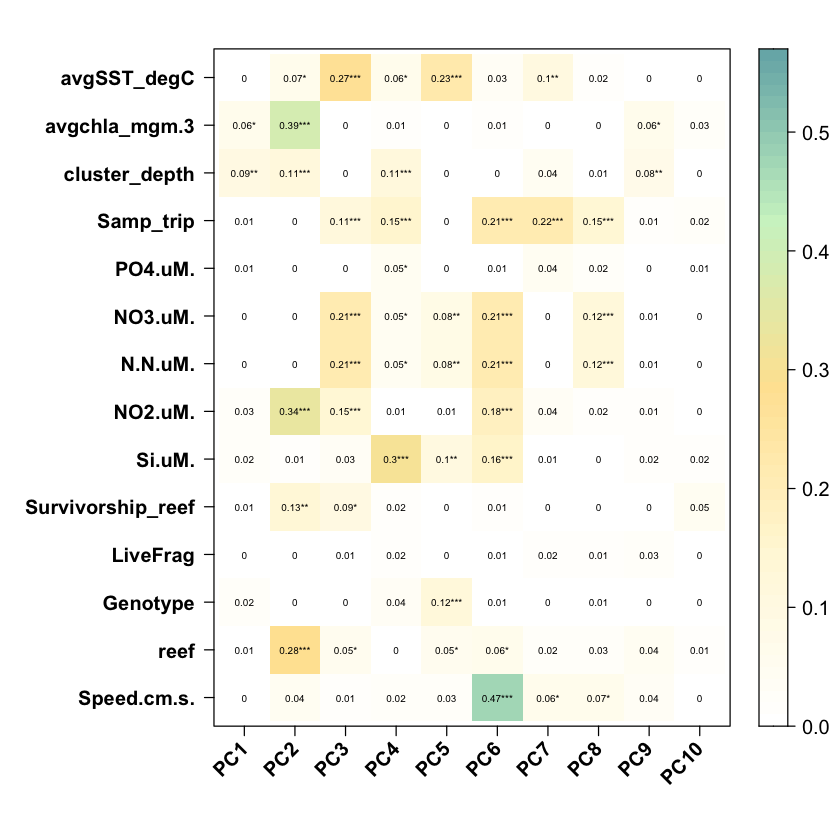

In [17]:
 eigencorplot(p,
    metavars = c('Si.uM.', 'NO2.uM.', 'N.N.uM.', 'NO3.uM.', 'PO4.uM.', "Samp_trip", "avgchla_mgm.3", "reef", "Genotype",
                "Speed.cm.s.", "avgSST_degC", 'cluster_depth', "Survivorship_reef",
                "LiveFrag"),
              col = c('white', 'cornsilk1', "#FFE4A1",  '#CFF3CA', "#77B3B5"),
    cexCorval = 0.5,
    fontCorval = 0.5,
    cexTitleX = 4,
    
    #posLab = 'all',
    rotLabX = 45,
    scale = TRUE,
    plotRsquared = TRUE,
    corFUN = 'spearman',
    corUSE = 'pairwise.complete.obs',
    corMultipleTestCorrection = 'BH')

### Model selection

In [18]:
ps_fill_ad =  subset_samples(ps_fill, cluster_depth!= "NA")
ps_fill_ad

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 481 taxa and 123 samples ]:
sample_data() Sample Data:        [ 123 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 481 taxa by 7 taxonomic ranks ]:
taxa are rows

In [19]:
ps_ad_clr<- microbiome::transform(ps_fill_ad, 'clr')

In [21]:
ps_clr_ad_meta1= ps_ra_ad_meta %>% select("Genotype", "Samp_trip", "reef","Survivorship",'Speed.cm.s.', 'NO2.uM.', 'N.N.uM.', 'NO3.uM.', 'PO4.uM.', 'Si.uM.',
                "Speed.cm.s.", "avgSST_degC", "avgchla_mgm.3", "Temperature.C.","cluster_depth")


cor(ps_clr_ad_meta1[4:14])

,Survivorship,Speed.cm.s.,NO2.uM.,N.N.uM.,NO3.uM.,PO4.uM.,Si.uM.,avgSST_degC,avgchla_mgm.3,Temperature.C.,cluster_depth
Survivorship,1.00000000,0.205158024,-0.1832054,0.085238501,0.088248633,-0.1181892,0.06501833,0.02603698,0.15771485,0.12482590,0.511641240
Speed.cm.s.,0.20515802,1.000000000,-0.5166973,-0.524687881,-0.522355146,0.2217949,0.55877828,0.10665937,-0.10669293,0.23591908,0.004143171
NO2.uM.,-0.18320541,-0.516697338,1.0000000,0.602919529,0.594757382,0.2165168,-0.39476538,0.67912714,0.33577654,0.48310555,0.158641583
N.N.uM.,0.08523850,-0.524687881,0.6029195,1.000000000,0.999947179,-0.2370421,-0.25530005,0.58092122,0.09790408,0.50852898,0.004724162
NO3.uM.,0.08824863,-0.522355146,0.5947574,0.999947179,1.000000000,-0.2421203,-0.25206521,0.57644090,0.09436105,0.50615634,0.002992115
PO4.uM.,-0.11818918,0.221794924,0.2165168,-0.237042080,-0.242120338,1.0000000,0.36098608,0.14796444,-0.29994055,0.27281337,-0.189955104
Si.uM.,0.06501833,0.558778282,-0.3947654,-0.255300046,-0.252065213,0.3609861,1.00000000,-0.04376603,-0.34283200,0.42196047,-0.235941126
avgSST_degC,0.02603698,0.106659370,0.6791271,0.580921218,0.576440896,0.1479644,-0.04376603,1.00000000,0.26782003,0.86266443,0.062454851
avgchla_mgm.3,0.15771485,-0.106692933,0.3357765,0.097904084,0.094361054,-0.2999406,-0.34283200,0.26782003,1.00000000,0.07646157,0.770175798
Temperature.C.,0.12482590,0.235919076,0.4831055,0.508528979,0.506156336,0.2728134,0.42196047,0.86266443,0.07646157,1.00000000,-0.016290979


In [22]:

ps_clr_ad_meta= data.frame(sample_data(ps_fill_ad))

#remove co-variate
ps_clr_ad_meta2 = ps_clr_ad_meta %>% select('NO2.uM.', 'NO3.uM.', 'PO4.uM.', 'Si.uM.',
                "Speed.cm.s.", "avgSST_degC", "cluster_depth", "Survivorship")

head(ps_clr_ad_meta2)
dim(ps_clr_ad_meta2)

,NO2.uM.,NO3.uM.,PO4.uM.,Si.uM.,Speed.cm.s.,avgSST_degC,cluster_depth,Survivorship
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ML2_78_cf_Trip_3,0.032,0.861,0.0685,0.706,4.852118,29.63623,-20.9,0.3571429
CN4_35_cf_Trip_3,0.032,0.861,0.0685,0.706,4.852118,29.63623,-17.9,0.6428571
CN4_25_cf_Trip_3,0.032,0.861,0.0685,0.706,4.852118,29.63623,-20.8,0.6428571
HS1_18_cf_Trip_3,0.032,0.861,0.0685,0.706,4.852118,29.63623,-18.8,0.7619048
HS1_17_cf_Trip_3,0.032,0.861,0.0685,0.706,4.852118,29.63623,-17.8,0.7619048
HS1_15_cf_Trip_3,0.032,0.861,0.0685,0.706,4.852118,29.63623,-17.6,0.7619048


[1] 123   8

In [23]:
mod0 <- rda(otu_table(t(ps_ad_clr)) ~ 1, ps_clr_ad_meta2)
mod1 <- rda(otu_table(t(ps_ad_clr)) ~ ., ps_clr_ad_meta2)
m <- ordistep(mod0, scope = formula(mod1), perm.max = 200, direction ="both")
m


Start: otu_table(t(ps_ad_clr)) ~ 1 

                Df    AIC      F Pr(>F)   
+ NO2.uM.        1 960.39 4.9746  0.005 **
+ avgSST_degC    1 961.06 4.2851  0.005 **
+ cluster_depth  1 961.49 3.8496  0.005 **
+ NO3.uM.        1 962.34 2.9940  0.005 **
+ Speed.cm.s.    1 962.55 2.7779  0.005 **
+ Si.uM.         1 963.37 1.9589  0.005 **
+ Survivorship   1 963.90 1.4309  0.050 * 
+ PO4.uM.        1 964.01 1.3174  0.070 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Step: otu_table(t(ps_ad_clr)) ~ NO2.uM. 

          Df    AIC      F Pr(>F)   
- NO2.uM.  1 963.34 4.9746  0.005 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                Df    AIC      F Pr(>F)   
+ avgSST_degC    1 958.74 3.6132  0.005 **
+ cluster_depth  1 958.89 3.4629  0.005 **
+ NO3.uM.        1 959.09 3.2611  0.005 **
+ Speed.cm.s.    1 959.10 3.2484  0.005 **
+ PO4.uM.        1 960.89 1.4693  0.020 * 
+ Si.uM.         1 960.89 1.4736  0.030 * 
+ Survivorship   1 960

Call: rda(formula = otu_table(t(ps_ad_clr)) ~ NO2.uM. + avgSST_degC +
Speed.cm.s. + cluster_depth + PO4.uM. + Si.uM. + NO3.uM., data =
ps_clr_ad_meta2)

                Inertia Proportion Rank
Total         2499.8160     1.0000     
Constrained    394.2778     0.1577    7
Unconstrained 2105.5382     0.8423  115
Inertia is variance 

Eigenvalues for constrained axes:
  RDA1   RDA2   RDA3   RDA4   RDA5   RDA6   RDA7 
136.82  77.71  55.29  49.83  36.35  20.84  17.43 

Eigenvalues for unconstrained axes:
   PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8 
257.35 115.71  82.11  66.37  55.32  44.65  40.72  37.68 
(Showing 8 of 115 unconstrained eigenvalues)


In [24]:
vif.cca(m)

NO2.uM.   avgSST_degC   Speed.cm.s. cluster_depth       PO4.uM. 
    13.419860     13.368275     11.650463      1.392638      2.336123 
       Si.uM.       NO3.uM. 
     2.030219      5.235383

In [25]:
anova(m,  by="term")

,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
NO2.uM.,1,98.71415,5.391556,0.001
avgSST_degC,1,70.18304,3.833248,0.001
Speed.cm.s.,1,69.25836,3.782744,0.001
cluster_depth,1,55.75710,3.045334,0.001
PO4.uM.,1,32.54223,1.777387,0.004
Si.uM.,1,30.95479,1.690685,0.005
NO3.uM.,1,36.86812,2.013658,0.002
Residual,115,2105.53821,NA,NA


In [26]:
anova(m, by="margin")

,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
NO2.uM.,1,58.79603,3.211313,0.001
avgSST_degC,1,39.21648,2.141921,0.002
Speed.cm.s.,1,42.44940,2.318495,0.001
cluster_depth,1,49.44186,2.700409,0.002
PO4.uM.,1,36.09778,1.971584,0.003
Si.uM.,1,38.58786,2.107587,0.003
NO3.uM.,1,36.86812,2.013658,0.004
Residual,115,2105.53821,NA,NA


In [27]:
anova(m)

,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,7,394.2778,3.076373,0.001
Residual,115,2105.5382,NA,NA


In [28]:
rda_veg=rda(otu_table(t(ps_ad_clr))  ~ NO2.uM. + NO3.uM. + PO4.uM. + Si.uM. +
                Speed.cm.s. +  avgSST_degC +  cluster_depth, data = ps_clr_ad_meta2, scale = TRUE)

In [29]:
 anova(rda_veg, by="axis")

,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
RDA1,1,25.947090,7.3113704,0.001
RDA2,1,14.226566,4.0087613,0.001
RDA3,1,10.193253,2.8722545,0.013
RDA4,1,8.699723,2.4514079,0.023
RDA5,1,6.361824,1.7926347,0.085
RDA6,1,4.149640,1.1692854,0.418
RDA7,1,3.302064,0.9304556,0.582
Residual,115,408.119840,NA,NA


In [30]:
envfit(rda_veg, ps_clr_ad_meta1, na.rm = TRUE, permutations = 999)


***VECTORS

                   RDA1     RDA2     r2 Pr(>r)    
Survivorship    0.90813 -0.41870 0.0061  0.681    
Speed.cm.s.     0.53449 -0.84518 0.0657  0.023 *  
NO2.uM.        -0.92147 -0.38845 0.4881  0.001 ***
N.N.uM.        -0.23746 -0.97140 0.2358  0.001 ***
NO3.uM.        -0.22312 -0.97479 0.2342  0.001 ***
PO4.uM.        -0.76088  0.64889 0.0135  0.468    
Si.uM.          0.89891 -0.43814 0.0908  0.004 ** 
avgSST_degC    -0.45732 -0.88930 0.7075  0.001 ***
avgchla_mgm.3  -0.99926  0.03842 0.4256  0.001 ***
Temperature.C. -0.32693 -0.94505 0.5662  0.001 ***
cluster_depth  -0.90184  0.43206 0.3129  0.001 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Permutation: free
Number of permutations: 999

***FACTORS:

Centroids:
                   RDA1    RDA2
GenotypeCN2     -0.0656  0.2281
GenotypeCN4     -0.1563 -0.1697
GenotypeHS1      0.0440 -0.1413
GenotypeML2      0.2016  0.0526
Samp_tripTrip_2  0.7555  1.5824
Samp_tripTrip_3 -0.5021 -1.8601
Samp_tripTrip